In [1]:
import os
import nltk
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lower, size, split
from pyspark.sql.types import ArrayType, StringType
from nltk.tokenize import word_tokenize

In [2]:
# Set  for NLTK
os.environ["NLTK_DATA"] = "/home/xyu8/nltk_data"

In [3]:
# Download NLTK assets
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/xyu8/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/xyu8/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config('spark.executor.instances', 7) \
    .getOrCreate()

In [5]:
df = sc.read.json("Electronics (1).jsonl")

In [6]:
# show basic info of the dataset
print(df.columns)
print("We have {} features".format(len(df.columns) - 1))
print("Total rows {}".format(df.count()))


['_corrupt_record', 'asin', 'helpful_vote', 'images', 'parent_asin', 'rating', 'text', 'timestamp', 'title', 'user_id', 'verified_purchase']
We have 10 features
Total rows 33567527


In [7]:
# Keep only the columns we care about: 'text' and 'rating'
new_review_df = df.drop(*['asin', 'helpful_vote', 'images', 'parent_asin', 'timestamp', 'title', 'user_id', 'verified_purchase'])
# Show a preview
new_review_df.show(5)

+---------------+------+--------------------+
|_corrupt_record|rating|                text|
+---------------+------+--------------------+
|           NULL|   3.0|First & most offe...|
|           NULL|   1.0|These didn’t work...|
|           NULL|   5.0|I love these. The...|
|           NULL|   5.0|I was searching f...|
|           NULL|   5.0|I've bought these...|
+---------------+------+--------------------+
only showing top 5 rows



In [8]:
# Drop the corrupt_record column 
new_review_df = new_review_df.drop('_corrupt_record')

In [9]:
# Remove rows with any null values
clean_review_df = new_review_df.na.drop()

# Show 10 sample rows
clean_review_df.show(10)

# Print total remaining row count
print("Total rows after removing nulls:", clean_review_df.count())

+------+--------------------+
|rating|                text|
+------+--------------------+
|   3.0|First & most offe...|
|   1.0|These didn’t work...|
|   5.0|I love these. The...|
|   5.0|I was searching f...|
|   5.0|I've bought these...|
|   5.0|Light weight, qui...|
|   5.0|Update 2-they sen...|
|   5.0|These are fantast...|
|   5.0|pretty good for t...|
|   5.0|yes.. so good.  j...|
+------+--------------------+
only showing top 10 rows

Total rows after removing nulls: 33567526


In [10]:
# Convert review text to lowercase
from pyspark.sql.functions import lower
clean_review_df = clean_review_df.withColumn("lower_text", lower("text"))
clean_review_df.show(5)


+------+--------------------+--------------------+
|rating|                text|          lower_text|
+------+--------------------+--------------------+
|   3.0|First & most offe...|first & most offe...|
|   1.0|These didn’t work...|these didn’t work...|
|   5.0|I love these. The...|i love these. the...|
|   5.0|I was searching f...|i was searching f...|
|   5.0|I've bought these...|i've bought these...|
+------+--------------------+--------------------+
only showing top 5 rows



### Preprocessing Step: Tokenize and Clean Text

In [11]:
# clean and tokenize review text
@udf(returnType=ArrayType(StringType()))
def tokenize_text(text):
    # Import stopwords and stemmer
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    if text:
        # Convert to lowercase and split by whitespace
        tokens = text.lower().split()
        # Stem words, remove stopwords and nonalphanumeric tokens
        return [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]
    
    return []

# Apply the tokenizer function to create a new column 'tokens'
clean_review_df = clean_review_df.withColumn("tokens", tokenize_text(col("lower_text")))

# Show the first 5 rows of lowercased text and tokens
clean_review_df.select("lower_text", "tokens").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
from pyspark.sql.functions import size, split

# Add new columns to clean_review_df
dataset = clean_review_df.withColumn("word_counts", size(split(col("lower_text"), " ")))
dataset = dataset.withColumn("tokenizes_count", size(col("tokens")))

# Display schema to confirm
dataset.printSchema()


root
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- lower_text: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- word_counts: integer (nullable = false)
 |-- tokenizes_count: integer (nullable = false)



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary cache directory at /scratch/xyu8/job_39190840/matplotlib-9lrrtxwx because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


/scratch/xyu8/job_39190840/ipykernel_130441/662800399.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y='count', data=rating_counts_pd, palette='Blues')


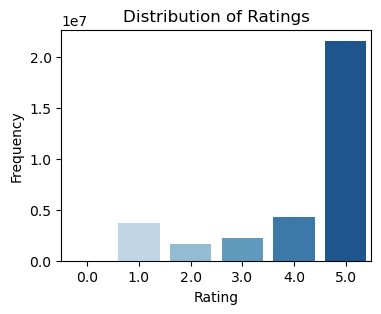

In [14]:
# Plot distribution of review ratings
rating_counts = dataset.groupBy("rating").count().orderBy("rating")
rating_counts_pd = rating_counts.toPandas()

plt.figure(figsize=(4, 3))
sns.barplot(x='rating', y='count', data=rating_counts_pd, palette='Blues')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

In [15]:
correlation_rating_word_counts = dataset.stat.corr("rating", "word_counts")
print(f"Correlation between rating and word_counts: {correlation_rating_word_counts}")


Correlation between rating and word_counts: -0.1048332260409987


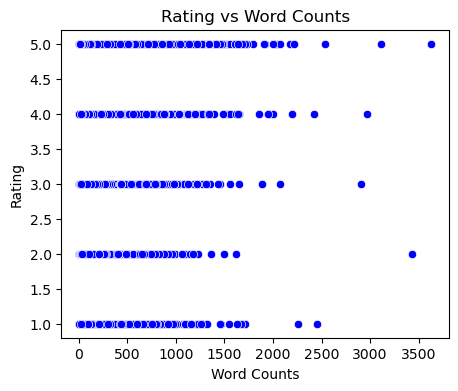

In [16]:
# Sample 1% of the dataset to reduce processing time
sampled_data = dataset.sample(fraction=0.01, seed=42)

# Select only the needed columns and convert to Pandas
sampled_data_pandas = sampled_data.select("rating", "word_counts").toPandas()

# Plotting
# This scatter plot shows the relationship between review length (word count) and rating.
# Each point represents a review. The x-axis is the number of words, and the y-axis is the rating 
# visualize whether longer or shorter reviews are associated with higher or lower ratings.
plt.figure(figsize=(5, 4))
sns.scatterplot(data=sampled_data_pandas, x='word_counts', y='rating', color='blue')
plt.title('Rating vs Word Counts')
plt.xlabel('Word Counts')
plt.ylabel('Rating')
plt.show()


In [17]:

from pyspark.sql.types import DoubleType
# Define UDF to compute average word length
# This function calculates the average number of characters per word in the token list.
def avg_word_length(tokens):
    return float(sum(len(w) for w in tokens) / len(tokens)) if tokens else 0.0

avg_word_length_udf = udf(avg_word_length, DoubleType())

# Add column to the dataset
dataset = dataset.withColumn("avg_word_length", avg_word_length_udf(col("tokens")))
dataset.select("tokens", "avg_word_length").show(5, truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
|tokens                                                                                                                                                                      

###taking too long for chart to show.

/scratch/xyu8/job_39190840/ipykernel_130441/1261095793.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="rating", y="avg_word_length", data=sampled_avg_len_df, palette="Set3")


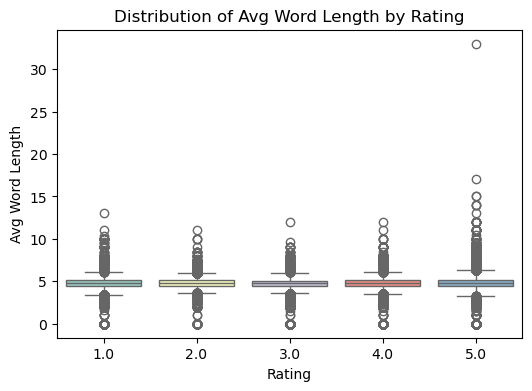

In [18]:
# distribution of average word lengths for each rating 
# Sample 1% of the dataset
sampled_avg_len_df = dataset.sample(fraction=0.01, seed=42).select("rating", "avg_word_length").toPandas()

# Plot using the smaller sample
plt.figure(figsize=(6, 4))
sns.boxplot(x="rating", y="avg_word_length", data=sampled_avg_len_df, palette="Set3")
plt.xlabel("Rating")
plt.ylabel("Avg Word Length")
plt.title("Distribution of Avg Word Length by Rating")
plt.show()